In [10]:
tess_sector = 1
downloaded_lc_basepath = f"../../downloaded_lc/tess_lc/"
catalogues_folder="../catalogues/tess_download_scripts/"

import warnings
warnings.filterwarnings(
    "ignore",
    message="Numerical value without unit or explicit format passed to TimeDelta, assuming days",
    module="astropy"
)
warnings.filterwarnings(
    "ignore",
    message="Numerical value without unit or explicit format passed to TimeDelta, assuming days",
    module="astropy"
)

warnings.filterwarnings(
    "ignore",
    message=".*Unit 'BJD' not supported by the FITS standard.*",
    module="astropy"
)

warnings.filterwarnings(
    "ignore",
    message=".*Unit 'e' not supported by the FITS standard.*",
    module="astropy"
)

warnings.filterwarnings(
    "ignore",
    message=".*'pixels' did not parse as fits unit*",
    module="astropy"
)

warnings.filterwarnings(
    "ignore",
    message=".*did not parse as fits unit*",
    module="astropy"
)

warnings.filterwarnings(
    "ignore",
    message=".*missing from current font*",
)

warnings.filterwarnings(
    "ignore",
    message=".*'partition' will ignore*",
)

warnings.filterwarnings(
    "ignore",
    message=".*DejaVu Sans*",
)
warnings.filterwarnings(
    "ignore",
    message=".*tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd*",
)

warnings.filterwarnings(
    "ignore",
    message=".*Liberation Sans*",
)

warnings.filterwarnings(
    "ignore",
    module="seaborn"
)


%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Go up one directory and into the sibling directory 'clara'
sibling_path = Path().resolve().parent / "clara"
sys.path.append(str(sibling_path))

import os
import numpy as np
from astropy.timeseries import LombScargle
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import pandas as pd
import itertools
from IPython.display import clear_output
import random
import glob
import shutil
from typing import List
import re

import clara_utils
import clara_viz
import clara_urf_helpers
import clara_feature_extraction_parallel as cfe
import clara_toi_functions
import clara_generate_synth_lc as gslc
import clara_urf_predictor as upred
import clara_urf4_subvariant_analysis as u4svan
import clara_urf4_test_suite as cuts

import time
import logging

import time as tm

# Setup logger once
logger = logging.getLogger("cell_timer_logger")
if not logger.handlers:
    handler = logging.FileHandler("../single_feature_tests/logs/cell_timing.log", mode='a')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# --- Define frequency range: 4 hours to 27 days ---
num_flux_points = 3000 # MG21 3000 flux light curve points
num_freq_points = 1000 # MG21 1000 points corresponding to the periodogram
min_period = 4 / 24  # 4 hours in days
max_period = 27      # 27 days
frequencies = np.logspace(np.log10(1 / max_period), np.log10(1 / min_period), num_freq_points)

In [12]:
def train_and_save_urf_synthetic(X_real,
                                      X_synthetic=None,
                                      model_filename="urf_model_URF3_synthetic_toi.pkl",
                                      save_model_path="../models/saved_URF_models/",
                                      n_iter=30,
                                      random_state=42):
    """
    Train and save a URF model using real light curve features and a synthetic class.

    Args:
        X_real (ndarray): Feature matrix of real light curves.
        X_synthetic (ndarray or None): Synthetic feature matrix. If None, uses uniform noise.
        model_filename (str): Filename to save the model under.
        save_model_path (str): Directory to save the model.
        n_iter (int): Number of random hyperparameter samples.
        random_state (int): Random seed for reproducibility.

    Returns:
        best_rf: Trained RandomForestClassifier model.
    """

    # Step 1: Use provided synthetic set or fall back to uniform noise
    if X_synthetic is not None:
        print(f"🔁 Using provided synthetic class with {len(X_synthetic)} samples.")
        X_fake = X_synthetic
    else:
        print("🔁 No synthetic class provided, using uniform noise.")
        X_fake = np.random.uniform(np.min(X_real), np.max(X_real), size=X_real.shape)

    # Step 2: Stack real and synthetic
    X_urf = np.vstack([X_real, X_fake])
    y_urf = np.array([1] * len(X_real) + [0] * len(X_fake))  # 1 = real, 0 = synthetic

    # Step 3: Define hyperparameter search space
    param_dist = {
        "n_estimators": np.linspace(50, 200, 10, dtype=int).tolist(),
        "max_features": ["sqrt", "log2"],
        "max_depth": [100, 300, 500, 700, 900, 1000, None],
        "min_samples_split": [2, 4, 7, 10],
        "min_samples_leaf": [1, 2],
        "bootstrap": [True, False],
        "warm_start": [True, False]
    }

    # Step 4: Randomized search
    clf = RandomForestClassifier(random_state=random_state)
    search = RandomizedSearchCV(
        clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=random_state
    )

    search.fit(X_urf, y_urf)
    best_rf = search.best_estimator_

    print("✅ Best hyperparameters found:")
    print(search.best_params_)

    # Step 5: Save model
    os.makedirs(save_model_path, exist_ok=True)
    full_path = os.path.join(save_model_path, model_filename)
    joblib.dump(best_rf, full_path)
    print(f"📦 Model saved to: {full_path}")

    return best_rf

In [183]:
def computeLombScargleTessLC(this_lc, 
                             num_flux_points=num_flux_points,
                             num_freq_points=num_freq_points):

    this_lc.flux = this_lc.flux.value
    this_lc.flux_err = this_lc.flux_err.value
    
    # --- Preprocess --- mask removes any NaNs, Infs and any missing or corrupted points
    time = this_lc.time.value
    flux = this_lc.flux
    mask = np.isfinite(time) & np.isfinite(flux)
    time, flux = time[mask], flux[mask]
    flux = (flux - np.mean(flux)) / np.std(flux)
    
    # --- Truncate or pad flux vector ---
    flux_vector = flux[:num_flux_points]
    if len(flux_vector) < num_flux_points:
        flux_vector = np.pad(flux_vector, (0, num_flux_points - len(flux_vector)))

    ls = LombScargle(time, flux)
    power = ls.power(frequencies)
    power_vector = power[:num_freq_points]

    feature_vector = np.concatenate([flux_vector, power_vector])
    # print(f"Feature vector shape: {feature_vector.shape}")

    return feature_vector, flux_vector, power_vector
    
def build_feature_matrix_from_loaded_subvar_synth_lcs(lcs_variant_folder,
                                         num_flux_points=num_flux_points,
                                         num_freq_points=num_freq_points,
                                         verbose=False,
                                         max_workers=8,
                                         save_folder="../single_feature_tests/data/saved_features/urf4_subvariant_synthetic_lcs_features_duration/",
                                         save_name_base=None):
    lightcurves, filenames = gslc.load_synthetic_lcs_from_npy(
        folder_path=lcs_variant_folder,
        filename_prefix=f"urf4_sub{lcs_variant_folder.split("/")[-1]}",
        sector_tag="SIM_URF4_SUBVAR_DUR"
    )
    if save_folder:
        save_folder = os.path.join(save_folder, lcs_variant_folder.split("/")[-1])
    def process_one_lc(lc_obj, fname):
        try:
            fv, _, _ = computeLombScargleTessLC(lc_obj,
                                                num_flux_points=num_flux_points,
                                                num_freq_points=num_freq_points)
            if fv.shape[0] == num_flux_points + num_freq_points:
                return fv, fname
        except Exception as e:
            if verbose:
                print(f"⚠️ {fname} failed: {e}")
        return None

    feature_list = []
    filename_list = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_one_lc, lc, fname)
            for lc, fname in zip(lightcurves, filenames)
        ]
        for fut in tqdm(as_completed(futures), total=len(futures),
                        desc=f"Building features for sub{lcs_variant_folder.split("/")[-1]}"):
            result = fut.result()
            if result is not None:
                fv, fname = result
                feature_list.append(fv)
                filename_list.append(fname)

    X = np.array(feature_list)

    if save_folder and save_name_base:
        os.makedirs(save_folder, exist_ok=True)
        features_path = os.path.join(save_folder, save_name_base + "_features.npy")
        filenames_path = os.path.join(save_folder, save_name_base + "_filenames.txt")

        np.save(features_path, X)
        with open(filenames_path, "w") as f:
            for fname in filename_list:
                f.write(fname + "\n")

        # print(f"✅ Saved features to {features_path}")
        # print(f"✅ Saved filenames to {filenames_path}")

    return X, filename_list

def train_feature_matrices_for_all_variants(base_variant_folder="../single_feature_tests/data/synthetic_lcs_variants/",
                                            num_flux_points=num_flux_points,
                                            num_freq_points=num_freq_points,
                                            max_workers=4,
                                            save_folder="../single_feature_tests/data/saved_features/urf4_subvariant_synthetic_lcs_features/"):

    # Collect all subvariant folders
    subvariant_folders = [os.path.join(base_variant_folder, d)
                          for d in os.listdir(base_variant_folder)
                          if os.path.isdir(os.path.join(base_variant_folder, d))]

    print(f"🔧 Starting feature extraction for {len(subvariant_folders)} variants...\n")

    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for result in executor.map(process_one_variant, subvariant_folders, [save_folder]*len(subvariant_folders)):
            results.append(result)

    print("\n✅ Feature extraction complete.")
    return results

def process_one_variant(variant_path, save_folder):
        variant_name = os.path.basename(variant_path)
        try:
            build_feature_matrix_from_loaded_subvar_synth_lcs(
                lcs_variant_folder=variant_path,
                num_flux_points=num_flux_points,
                num_freq_points=num_freq_points,
                verbose=False,
                max_workers=8,
                save_folder=save_folder,
                save_name_base=f"urf4_sub_{variant_name}"
            )
            return f"[✓] Processed {variant_name}"
        except Exception as e:
            return f"[✗] Failed {variant_name}: {e}"

def train_model_for_variant(variant_folder, features_folder, X_real, save_model_folder, model_prefix):
    try:
        variant_path = os.path.join(features_folder, variant_folder)
        feature_file = os.path.join(variant_path, f"urf4_sub_{variant_folder}_features.npy")

        if not os.path.exists(feature_file):
            return f"[✗] Skipping {variant_folder}: Feature file not found."

        X_synthetic = np.load(feature_file)
        model_filename = f"{model_prefix}_{variant_folder}.pkl"

        _ = train_and_save_urf_synthetic(
            X_real=X_real,
            X_synthetic=X_synthetic,
            model_filename=model_filename,
            save_model_path=save_model_folder
        )
        return f"[✓] Finished training for {variant_folder}"

    except Exception as e:
        return f"[✗] Failed training for {variant_folder}: {e}"


def train_urf4_models_for_all_variants(
    features_folder="../single_feature_tests/data/saved_features/urf4_subvariant_synthetic_lcs_features/",
    real_feature_path="../single_feature_tests/data/saved_features/urf_training_features/urf_training_feature_run2.npy",
    save_model_folder="../single_feature_tests/models/saved_URF4_subvariants/",
    model_prefix="urf4_model"
):
    import time as tm

    os.makedirs(save_model_folder, exist_ok=True)

    X_real = np.load(real_feature_path)
    variant_folders = [
        f for f in os.listdir(features_folder)
        if os.path.isdir(os.path.join(features_folder, f))
    ]
    count = 0
    for variant in variant_folders:
        print(count+1)
        result = train_model_for_variant(variant, features_folder, X_real, save_model_folder, model_prefix)
        count += 1
        clear_output(wait=True)
        print(f"{count}/{len(variant_folders)} urf4 subvariant models saved")
        # if count in [4,8,12,16,20,24,28,32]:
        #     tm.sleep(400)

In [ ]:
def compute_importance_vs_threshold(
    csv_folder: str,
    toi_filename_list: list,
    toi_importance_df: pd.DataFrame,
    thresholds=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
) -> pd.DataFrame:
    """
    Computes average normalized TOI importance score at various anomaly score thresholds.

    Returns
    -------
    pd.DataFrame with columns:
        ['variant', 'threshold_percent', 'n_tois_flagged', 'avg_normalized_importance']
    """
    import pandas as pd
    import os

    all_records = []

    # Quick filename to importance lookup
    # importance_lookup = dict(zip(toi_importance_df['filename'], toi_importance_df['normalized_score']))
    importance_lookup = dict(zip(toi_importance_df['filename'], toi_importance_df['normalized_score']))

    for fname in sorted(os.listdir(csv_folder)):
        if not fname.endswith(".csv"):
            continue

        variant = fname.replace(".csv", "")
        df = pd.read_csv(os.path.join(csv_folder, fname))
        df_sorted = df.sort_values(by="anomaly_score", ascending=False).reset_index(drop=True)
        n_total = len(df_sorted)

        for threshold in thresholds:
            top_n = int(n_total * threshold / 100)
            df_thresh = df_sorted.iloc[:top_n]

            # Flagged TOIs in top N
            flagged_tois = df_thresh[df_thresh['filename'].isin(toi_filename_list)].copy()

            # Map importance
            flagged_tois['normalized_importance'] = flagged_tois['filename'].map(importance_lookup)

            avg_importance = flagged_tois['normalized_importance'].mean() if not flagged_tois.empty else 0.0
            max_importance = flagged_tois['normalized_importance'].max() if not flagged_tois.empty else 0.0

            all_records.append({
                'variant': variant,
                'threshold_percent': threshold,
                'n_tois_flagged': len(flagged_tois),
                'avg_normalized_importance': avg_importance,
                "max_normalized_importance": max_importance
            })

    return pd.DataFrame(all_records)

In [39]:
def calculate_auc_metrics_from_results_v4(
    results_dir,
    sector_no,
    fits_dir = None,
    first_n=None,
    top_percent=20
):
    import glob
    import os
    import traceback
    import test_helpers.gen_rep_test_set as grts
    import test_helpers.toi_importance as timp
    import clara_toi_functions as ctoi
    import clara_urf_predictor as cupred
    import pandas as pd
    from scipy.integrate import trapezoid
    from IPython.display import clear_output
    import numpy as np

    def mean_importance_in_top_n(df, toi_filenames, importance_df, top_percent=10):
        n = int(len(df) * top_percent / 100)
        df_top = df.sort_values("anomaly_score", ascending=False).head(n)
        df_top = df_top[df_top["filename"].isin(toi_filenames)]
        return df_top["normalized_score"].mean()

    def anomaly_score_percentile_range_for_top_important_tois(
        result_df,
        toi_filenames,
        top_n_percent=10
    ):
        # Filter to TOIs with valid importance scores
        df = result_df[result_df["filename"].isin(toi_filenames)].copy()
        df = df.dropna(subset=["normalized_score"])
    
        if df.empty:
            raise ValueError("No valid TOIs with importance scores found in result_df.")
    
        # Get top-N% TOIs by importance
        n_top = max(1, int(len(df) * top_n_percent / 100))
        df_top = df.sort_values("normalized_score", ascending=False).head(n_top)
    
        # Rank entire dataset by anomaly score to get percentiles
        df_all = result_df.copy()
        df_all = df_all.sort_values("anomaly_score", ascending=False).reset_index(drop=True)
        df_all["anomaly_percentile"] = df_all.index / len(df_all) * 100
    
        # Merge top important TOIs with their anomaly percentiles
        df_top = df_top.merge(
            df_all[["filename", "anomaly_percentile"]],
            on="filename",
            how="left"
        )
    
        lower = df_top["anomaly_percentile"].min()
        upper = df_top["anomaly_percentile"].max()
    
        return lower, upper, df_top.sort_values("anomaly_percentile")

    if fits_dir is None:
        all_fits_fnames = [x.split("/")[-1] for x in glob.glob(os.path.join(f"../../downloaded_lc/tess_lc/{sector_no}/", '*.fits'))]
    else:
        all_fits_fnames = [x.split("/")[-1] for x in glob.glob(os.path.join(fits_dir, '*.fits'))]
    print("Accessing TOI data from: https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")
    sector_toi_tics = ctoi.get_sector_tic_ids(sector=sector_no)
    toi_filenames = [x for x in all_fits_fnames if x.endswith(".fits") and int(x.split("-")[2].lstrip("0")) in sector_toi_tics]

    all_results = []
    for path in glob.glob(os.path.join(results_dir, "*_2.csv")):
        try:
            df = pd.read_csv(path)
            all_results.append((df, os.path.basename(path)))
        except Exception as e:
            print(f"Skipping {path}: {e}")

    if not all_results:
        raise RuntimeError("No valid result CSVs found.")

    auc_records = []

    if first_n:
        all_results = all_results[:first_n]

    for result, variant_name in all_results:
        print(f"Calculating auc metrics for result: {variant_name}")
        result = result.copy()
        result['is_toi'] = result['filename'].isin(toi_filenames)

        sample_tois = result[result["filename"].isin(toi_filenames)]["filename"].tolist()
        sample_tic_ids = [int(x.split("-")[2].lstrip("0")) for x in sample_tois]

        result_toi_df = timp.get_toi_importance_scores_from_filenames(
            toi_filenames=sample_tois,
            sector_tic_ids=sample_tic_ids
        )

        print(result_toi_df.columns.tolist())

        result["tic_id"] = result["filename"].apply(lambda f: int(f.split("-")[2].lstrip("0")))
        result = result.merge(result_toi_df[["tic_id", "normalized_score"]], how="left", left_on="tic_id", right_on="tic_id")

        n_total = len(result)
        n_tois_total = result["is_toi"].sum()
        total_importance = result.loc[result["is_toi"], "normalized_score"].sum()

        if n_tois_total == 0:
            print(f"[!] No TOIs found in result: {variant_name}. Skipping.")
            continue

        thresholds = list(range(5, 101, 5))
        recall_values = []
        importance_values = []
        threshold_fracs = []
        tot_anomaly_toi = result[result["is_toi"]]["anomaly_score"].gt(0).sum()
        n_anomaly = result["anomaly_score"].gt(0).sum()
        anomaly_rate = n_anomaly / n_total
        toi_recall_tot = tot_anomaly_toi / n_tois_total
        result = result.sort_values("anomaly_score", ascending=False).reset_index(drop=True)

        for threshold in thresholds:
            top_n = int(n_total * threshold / 100)
            df_thresh = result.iloc[:top_n]
            n_flagged_toi = df_thresh["is_toi"].sum()
            toi_recall = n_flagged_toi / n_tois_total
            importance_flagged = df_thresh.loc[df_thresh["is_toi"], "normalized_score"].mean() if not df_thresh["is_toi"].empty else 0.0
            recall_values.append(toi_recall)
            importance_values.append(importance_flagged)
            threshold_fracs.append(threshold / 100)

        recall_auc = np.trapezoid(recall_values, threshold_fracs)
        importance_auc = np.trapezoid(importance_values, threshold_fracs)

        mean_top_n_importance = mean_importance_in_top_n(result[result["anomaly_score"] > 0], toi_filenames, result_toi_df, top_percent=top_percent)

        lower_10, upper_10, ranked_top_tois_10 = anomaly_score_percentile_range_for_top_important_tois(
            result_df=result[result["anomaly_score"] > 0],
            toi_filenames=toi_filenames,
            top_n_percent=10
        )

        lower_20, upper_20, ranked_top_tois_20 = anomaly_score_percentile_range_for_top_important_tois(
            result_df=result[result["anomaly_score"] > 0],
            toi_filenames=toi_filenames,
            top_n_percent=20
        )

        auc_records.append({
            "variant": variant_name,
            "auc_toi_recall": recall_auc,
            "auc_importance_recall": importance_auc,
            "mean_importance_top{}p".format(top_percent): mean_top_n_importance,
            "toi_recall": toi_recall_tot,
            "top_10p_by_importance_percentile_range_lower":lower_10,
            "top_10p_by_importance_percentile_range_upper":upper_10,
            "top_10p_by_importance_percentile_range_ranked_top_tois":ranked_top_tois_10,
            "top_20p_by_importance_percentile_range_lower":lower_20,
            "top_20p_by_importance_percentile_range_upper":upper_20,
            "top_20p_by_importance_percentile_range_ranked_top_tois":ranked_top_tois_20,
            "anomaly_rate": anomaly_rate
        })

    return pd.DataFrame(auc_records)


In [199]:
import pandas as pd
import re

def get_best_model_by_alpha(metrics_df, alpha=0.5,
                            n_range=None, d_range=None, c_range=None, nppm_range=None, beta=0.1):
    df = metrics_df.copy()

    # Extract n, d, c, n_ppm from variant string
    def extract_params(s):
        match = re.search(r'n(\d+)_d(\d+)_c(\d+)_n(\d+)ppm', s)
        if match:
            return pd.Series(map(int, match.groups()))
        return pd.Series([None, None, None, None])

    df[['n', 'd', 'c', 'n_ppm']] = df['variant'].apply(extract_params)

    # Apply parameter filters
    if n_range:
        df = df[df['n'].between(n_range[0], n_range[1])]
    if d_range:
        df = df[df['d'].between(d_range[0], d_range[1])]
    if c_range:
        df = df[df['c'].between(c_range[0], c_range[1])]
    if nppm_range:
        df = df[df['n_ppm'].between(nppm_range[0], nppm_range[1])]

    if df.empty:
        raise ValueError("No models match the provided filter ranges.")

    # Normalize metrics
    recall = (df["toi_recall"] - df["toi_recall"].min()) / (df["toi_recall"].max() - df["toi_recall"].min())
    anomaly = (df["anomaly_rate"] - df["anomaly_rate"].min()) / (df["anomaly_rate"].max() - df["anomaly_rate"].min())
    importance_range = (df["top_10p_by_importance_percentile_range_upper"] - df["top_10p_by_importance_percentile_range_upper"].min()) / (
        df["top_10p_by_importance_percentile_range_upper"].max() - df["top_10p_by_importance_percentile_range_upper"].min())

    # Invert importance_range so lower = better
    inverted_importance = 1 - importance_range

    # Combined score
    df["combined_score"] = alpha * recall + (1 - alpha) * inverted_importance - beta * anomaly

    # Return best model row
    return df.sort_values("combined_score", ascending=False).iloc[0]

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sweep_beta_grid_plot(metrics_df,
                         n_range=None, d_range=None, c_range=None, nppm_range=None):
    alphas = [round(a, 1) for a in np.arange(0.0, 1.01, 0.1)]
    betas = [round(b, 1) for b in np.arange(0.1, 1.0, 0.1)]

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    all_results = []

    for idx, beta in enumerate(betas):
        results = []

        for alpha in alphas:
            try:
                best = get_best_model_by_alpha(
                    metrics_df, alpha,
                    n_range=n_range,
                    d_range=d_range,
                    c_range=c_range,
                    nppm_range=nppm_range,
                    beta=beta
                )
                results.append({
                    "alpha": alpha,
                    "best_nppm": best["n_ppm"],
                    "variant": best["variant"],
                    "score": best["combined_score"]
                })
            except ValueError:
                results.append({
                    "alpha": alpha,
                    "best_nppm": None,
                    "variant": None,
                    "score": None
                })

        df_beta = pd.DataFrame(results)
        all_results.append((beta, df_beta))

        # Plot this beta’s alpha sweep
        ax = axes[idx]
        ax.plot(df_beta["alpha"], df_beta["best_nppm"], marker='o', color='tab:blue')
        ax.set_title(f"β = {beta}")
        ax.set_xlabel("Alpha")
        ax.set_ylabel("Best n_ppm")
        ax.grid(True)

    plt.suptitle("Best Noise PPM vs Alpha for Different Beta Values", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
    plt.show()

    return all_results
    return results_df


In [17]:
def run_urf4_predictions_all_models(
    model_dir,
    lightcurve_folder,
    result_dir,
    max_workers=4,
    cooldown_seconds=600 # 10 min cooldown after approx 70 mins of processing for 36 times
):
    os.makedirs(result_dir, exist_ok=True)

    model_filenames = sorted([
        f for f in os.listdir(model_dir)
        if f.endswith(".pkl") and f.startswith("urf4_model")
    ])

    for i, model_file in enumerate(model_filenames, 1):
        model_path = os.path.join(model_dir, model_file)

        # Construct a matching CSV name
        result_csv = os.path.join(
            result_dir,
            model_file.replace(".pkl", "_anomaly_scores_sector_2.csv")
        )

        print(f"\n=== [{i}/{len(model_filenames)}] Running: {model_file} ===")
        upred.get_anomaly_scores_from_folder_parallelized_streamed_mp(
            folder_path=lightcurve_folder,
            model_path=model_path,
            save_csv=result_csv,
            save_dir=None,
            max_workers=max_workers
        )

        print(f"✅ Done: {model_file} → {result_csv}")
        if i < len(model_filenames):
            print(f"🕒 Cooling down for {cooldown_seconds} seconds...\n")
            import time as tm
            tm.sleep(cooldown_seconds)


Stage 1: Vary Noise_PPM
Fix: n_transits = 300, duration_hr = 13, cadence_min = 2

Vary: noise_ppm = [50, 100, 150, 200, 300]

Goal: Confirm importance trend and see if recall stays robust at low noise

Stage 2: Vary N_Transits
Fix noise_ppm = 50 (from stage 1 best case), duration_hr = 3, cadence_min = 2

Vary: n_transits = [100, 200, 300, 400]

Goal: See the trade-off between recall/anomaly rate and importance when transits vary under stable low-noise conditions



In [14]:
start = tm.time() # log time taken to generate synthetic data
# Generating synthetic lightcurves for training urf 4 subvariants

param_grid = {
    'n_curves': [300],
    'lc_length_days': [13.5],
    'cadence_minutes': [2.0],
    'noise_level': [
        25e-6, 50e-6, 75e-6, 100e-6, 125e-6, 150e-6, 175e-6, 200e-6, 225e-6, 250e-6, 275e-6, 300e-6, 400e-6, 600e-6, 800e-6
    ],
}

# Create all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['n_curves'],
    param_grid['lc_length_days'],
    param_grid['cadence_minutes'],
    param_grid['noise_level'],
))

# Base output path
base_output_folder = "../single_feature_tests/data/synthetic_lcs_variants/"
os.makedirs(base_output_folder, exist_ok=True)

# Generate and save synthetic light curves with progress bar
for idx, (n, dur, cad, noise) in enumerate(tqdm(param_combinations, desc="Generating Synthetic Variants")):
    # Generate synthetic light curves
    clear_output(wait=True)
    synthetic_lcs, time, model_types = gslc.generate_mixed_transit_lcs(
        n_curves=n,
        lc_length_days=dur,
        cadence_minutes=cad,
        noise_level=noise,
        random_state=42  # for reproducibility
    )

    # Format and create the output directory
    folder_name = f"variant_n{n}_d{int(dur)}_c{int(cad)}_n{int(noise*1e6)}ppm"
    output_folder = os.path.join(base_output_folder, folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Save the synthetic light curves
    gslc.save_synthetic_lcs_npy(
        synthetic_lcs,
        time_vector=time,
        model_types=model_types,
        output_folder=output_folder,
        filename_prefix=f"urf4_sub{output_folder.split("/")[-1]}",
        sector_tag="SIM_URF4_SUBVAR"
    )

    # Finished log line
    print(f"[✓] Saved variant {idx + 1}/{len(param_combinations)} to: {output_folder}")

end = tm.time()
logger.info(f"Cell runtime (Synthetic curve generation): {end - start:.2f} seconds")

🕒 Saved shared time vector: ../single_feature_tests/data/synthetic_lcs_variants/variant_n300_d13_c2_n800ppm/urf4_subvariant_n300_d13_c2_n800ppm_SIM_URF4_SUBVAR_time.npy


Generating Synthetic Variants: 100%|████████████| 15/15 [00:04<00:00,  3.57it/s]

✅ Saved 300 synthetic light curves to: ../single_feature_tests/data/synthetic_lcs_variants/variant_n300_d13_c2_n800ppm
[✓] Saved variant 15/15 to: ../single_feature_tests/data/synthetic_lcs_variants/variant_n300_d13_c2_n800ppm


In [15]:
start = tm.time()
train_feature_matrices_for_all_variants()
end = tm.time()
logger.info(f"Cell runtime (Feature extraction time from synthetic curves): {end - start:.2f} seconds")

🔧 Starting feature extraction for 15 variants...



Building features for subvariant_n300_d13_c2_n400ppm: 100%|█| 300/300 [01:38<00:
Building features for subvariant_n300_d13_c2_n800ppm: 100%|█| 300/300 [01:50<00:
Building features for subvariant_n300_d13_c2_n275ppm: 100%|█| 300/300 [01:41<00:
Building features for subvariant_n300_d13_c2_n125ppm: 100%|█| 300/300 [01:46<00:
Building features for subvariant_n300_d13_c2_n225ppm: 100%|█| 300/300 [01:51<00:
Building features for subvariant_n300_d13_c2_n175ppm: 100%|█| 300/300 [01:38<00:
Building features for subvariant_n300_d13_c2_n50ppm: 100%|█| 300/300 [01:48<00:0
Building features for subvariant_n300_d13_c2_n25ppm: 100%|█| 300/300 [01:50<00:0
Building features for subvariant_n300_d13_c2_n300ppm: 100%|█| 300/300 [01:51<00:
Building features for subvariant_n300_d13_c2_n75ppm: 100%|█| 300/300 [01:49<00:0
Building features for subvariant_n300_d13_c2_n600ppm: 100%|█| 300/300 [01:23<00:
Building features for subvariant_n300_d13_c2_n200ppm: 100%|█| 300/300 [01:51<00:
Building features for subvar


✅ Feature extraction complete.


In [16]:
start = tm.time()
train_urf4_models_for_all_variants()
end = tm.time()
logger.info(f"Cell runtime (Training and saving urf models): {end - start:.2f} seconds")

15/15 urf4 subvariant models saved


In [19]:
# download test set
start = tm.time()
download_tess_sector_out_log = f"../single_feature_tests/logs/download_tess_sector_1.logs"
clara_utils.download_tess_sector_threaded(sector_number=1, catalogues_folder=catalogues_folder,
                         out_dir_tess="../single_feature_tests/data/test_set/",
                         start_index=0,
                         max_downloads=4000,
                         log_file=download_tess_sector_out_log,
                         num_threads=8
)
end = tm.time()
logger.info(f"Cell runtime (Downloading Trend Prediction Test Set (labelled data, sector1, 4000 curves)): {end - start:.2f} seconds")

🌐 Found 15889 FITS files in sector 1


✅ Last successfully downloaded: tess2018206045859-s0001-0000000260537783-0120-s_lc.fits


In [20]:
if __name__ == '__main__':
    start = tm.time()
    run_urf4_predictions_all_models(
        model_dir="../single_feature_tests/models/saved_URF4_subvariants/", # subvariant models
        lightcurve_folder="../single_feature_tests/data/test_set/1/", # test set
        result_dir="../single_feature_tests/results/test_set_1/", # save results
        max_workers=4, # CPU has 4 cores, so...
        cooldown_seconds=200  # 10 min cooldown after approx 25 mins of processing for 36 times
    )
    end = tm.time()
    logger.info(f"Cell runtime (Running all 15 noise ppm variant models on test set 1): {end - start:.2f} seconds")

✅ Anomalies found: 3630


Scoring light curves (MP): 100%|████████████| 4000/4000 [18:38<00:00,  3.58it/s]

✅ Multiprocessing scoring complete. Results in: ../single_feature_tests/results/test_set_1/urf4_model_variant_n300_d13_c2_n800ppm_anomaly_scores_sector_2.csv
✅ Done: urf4_model_variant_n300_d13_c2_n800ppm.pkl → ../single_feature_tests/results/test_set_1/urf4_model_variant_n300_d13_c2_n800ppm_anomaly_scores_sector_2.csv


In [23]:
test_fits = [x for x in os.listdir("../single_feature_tests/data/test_set/1/") if x.endswith(".fits")]
tois_sect_1 = clara_toi_functions.get_sector_tic_ids(1)
toi_fits_list_test_set = [x for x in test_fits if int(x.split("-")[2].lstrip("0")) in tois_sect_1]
correlation_summary_urf4_subvariants = u4svan.evaluate_urf4_variants(
    csv_folder="../single_feature_tests/results/test_set_1/",
    toi_filename_list=toi_fits_list_test_set,
    output_csv_path="../single_feature_tests/results/urf4_correlation_results/correlation_table_urf4sv_s1_test_set_1.csv",
    threshold_percent=50
)

✅ Summary saved to: ../single_feature_tests/results/urf4_correlation_results/correlation_table_urf4sv_s1_test_set_1.csv


In [210]:
metrics_df = calculate_auc_metrics_from_results_v4(results_dir="../single_feature_tests/results/test_set_1/",
                                      sector_no=1,
                                      fits_dir="../single_feature_tests/data/test_set/1/",
                                     )

Accessing TOI data from: https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv
Calculating auc metrics for result: urf4_model_variant_n300_d13_c2_n50ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d13_c2_n400ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d13_c2_n125ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d13_c2_n300ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d13_c2_n100ppm_ano

KeyError: 'filename'

In [42]:
df_summary = correlation_summary_urf4_subvariants.copy()
df_summary.head()

,variant,n_transits,duration_hr,cadence_min,noise_ppm,n_total,n_anomalies,n_tois_total,n_tois_flagged,anomaly_rate,toi_recall,threshold_percent,n_thresholded,n_tois_thresholded,thresholded_toi_recall,thresholded_anomaly_rate
0,urf4_model_variant_n300_d13_c2_n50ppm_anomaly_...,300,13,2,5,4000,1168,59,18,0.29200,0.305085,50,4000,59,1.000000,1.00000
1,urf4_model_variant_n300_d13_c2_n400ppm_anomaly...,300,13,2,40,4000,3255,59,47,0.81375,0.796610,50,2095,31,0.525424,0.52375
2,urf4_model_variant_n300_d13_c2_n125ppm_anomaly...,300,13,2,12,4000,1161,59,20,0.29025,0.338983,50,4000,59,1.000000,1.00000
3,urf4_model_variant_n300_d13_c2_n300ppm_anomaly...,300,13,2,30,4000,2349,59,40,0.58725,0.677966,50,2026,33,0.559322,0.50650
4,urf4_model_variant_n300_d13_c2_n100ppm_anomaly...,300,13,2,10,4000,1815,59,26,0.45375,0.440678,50,4000,59,1.000000,1.00000


In [211]:
metrics_df[["variant", "toi_recall", "anomaly_rate", "top_10p_by_importance_percentile_range_upper", "mean_importance_top20p"]].head()

,variant,toi_recall,anomaly_rate,top_10p_by_importance_percentile_range_upper,mean_importance_top20p
0,urf4_model_variant_n300_d13_c2_n50ppm_anomaly_...,0.260870,0.292342,1.706485,0.233336
1,urf4_model_variant_n300_d13_c2_n400ppm_anomaly...,0.695652,0.813170,24.325153,0.437437
2,urf4_model_variant_n300_d13_c2_n125ppm_anomaly...,0.195652,0.289598,60.551249,0.233336
3,urf4_model_variant_n300_d13_c2_n300ppm_anomaly...,0.717391,0.587927,90.453967,0.181547
4,urf4_model_variant_n300_d13_c2_n100ppm_anomaly...,0.413043,0.453979,55.659341,0.233336


In [212]:
metrics_df.to_csv("../single_feature_tests/results/variant_ppm_testset_1_metrics_df.csv")

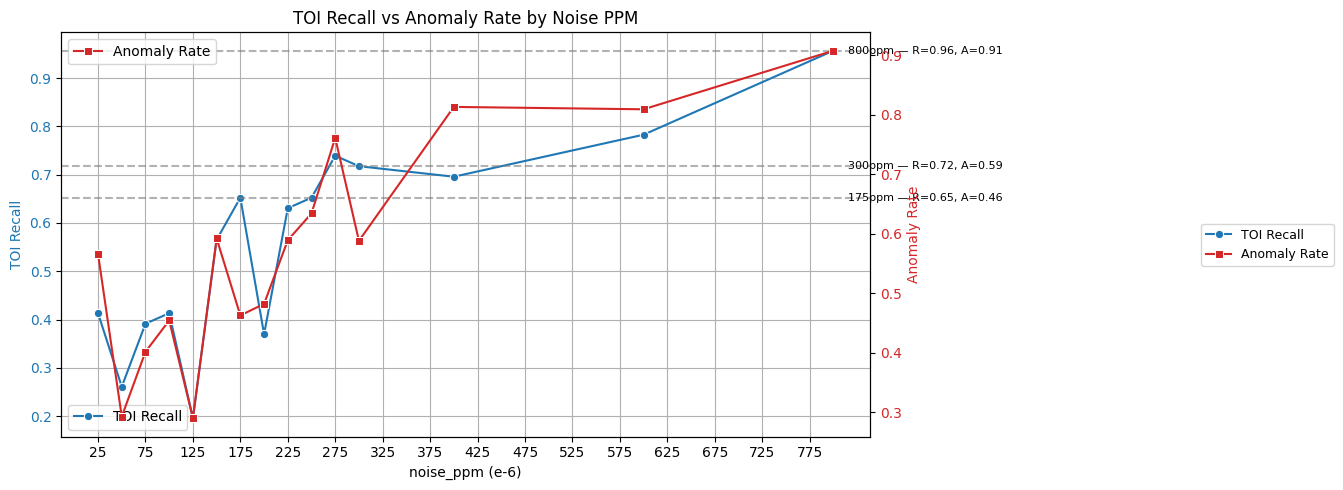

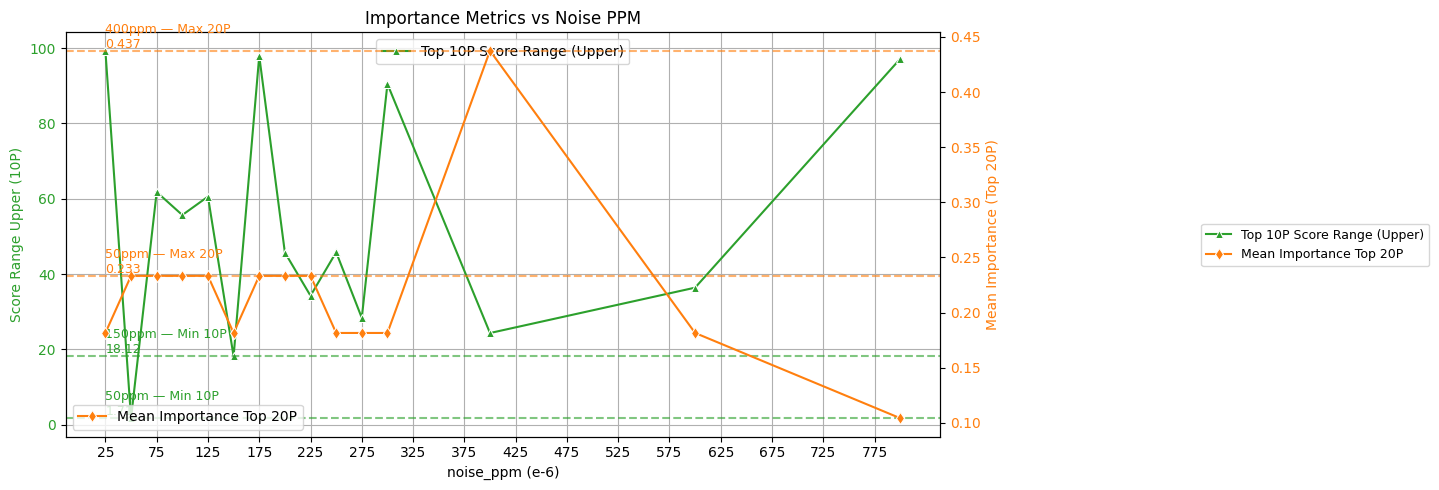

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_dual_metric_noise_ppm(df):
    # Extract noise_ppm from variant string
    df['noise_ppm'] = df['variant'].apply(lambda s: int(s.split("_")[6][1:-3]))
    x_vals = df['noise_ppm']

    # ==== Plot 1: TOI Recall vs Anomaly Rate ====
    fig1, ax1 = plt.subplots(figsize=(12, 5))
    ax2 = ax1.twinx()

    l1 = sns.lineplot(x=x_vals, y=df['toi_recall'], ax=ax1, color='tab:blue', marker='o', label='TOI Recall')
    l2 = sns.lineplot(x=x_vals, y=df['anomaly_rate'], ax=ax2, color='tab:red', marker='s', label='Anomaly Rate')

    ax1.set_xlabel('noise_ppm (e-6)')
    ax1.set_ylabel('TOI Recall', color='tab:blue')
    ax2.set_ylabel('Anomaly Rate', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_title('TOI Recall vs Anomaly Rate by Noise PPM')
    ax1.grid(True)

    # External legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig1.legend(handles1 + handles2, labels1 + labels2,
                loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=9)
    
    # Annotate top 3 where Recall > Anomaly Rate
    eligible = df[df['toi_recall'] > df['anomaly_rate']].copy()
    eligible['delta'] = eligible['toi_recall'] - eligible['anomaly_rate']
    top_rows = eligible.nlargest(3, 'delta')

    max_x = x_vals.max()
    x_offset = max_x * 0.02

    for _, row in top_rows.iterrows():
        noise_scaled = row['noise_ppm']
        recall = row['toi_recall']
        anomaly = row['anomaly_rate']
        ax1.axhline(y=recall, color='gray', linestyle='--', alpha=0.6)
        ax1.annotate(
            f"{int(noise_scaled)}ppm — R={recall:.2f}, A={anomaly:.2f}",
            xy=(max_x + x_offset, recall),
            fontsize=8, color='black', ha='left', va='center'
        )

    xticks = list(range(min(x_vals), max(x_vals)+1, 50))
    ax1.set_xticks(xticks)


    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
    plt.savefig("../single_feature_tests/figures/plot1_toi_recall_vs_anomaly_rate.png")
    plt.show()

    # ==== Plot 2: Importance Metrics ====
    fig2, ax3 = plt.subplots(figsize=(12, 5))
    ax4 = ax3.twinx()

    l3 = sns.lineplot(x=x_vals, y=df['top_10p_by_importance_percentile_range_upper'],
                      ax=ax3, color='tab:green', marker='^', label='Top 10P Score Range (Upper)')
    l4 = sns.lineplot(x=x_vals, y=df['mean_importance_top20p'],
                      ax=ax4, color='tab:orange', marker='d', label='Mean Importance Top 20P')

    ax3.set_xlabel('noise_ppm (e-6)')
    ax3.set_ylabel('Score Range Upper (10P)', color='tab:green')
    ax4.set_ylabel('Mean Importance (Top 20P)', color='tab:orange')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax4.tick_params(axis='y', labelcolor='tab:orange')
    ax3.set_title('Importance Metrics vs Noise PPM')
    ax3.grid(True)

    # External legend
    handles3, labels3 = ax3.get_legend_handles_labels()
    handles4, labels4 = ax4.get_legend_handles_labels()
    fig2.legend(handles3 + handles4, labels3 + labels4,
                loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=9)

    # === Lowest two of 10P Score Range (green axis) ===
    top10p_sorted = df.nsmallest(2, 'top_10p_by_importance_percentile_range_upper')
    for _, row in top10p_sorted.iterrows():
        y = row['top_10p_by_importance_percentile_range_upper']
        x_ppm = row['noise_ppm']
        ax3.axhline(y=y, color='tab:green', linestyle='--', alpha=0.6)
        ax3.annotate(f"{x_ppm}ppm — Min 10P\n{y:.2f}",
                     xy=(x_vals.min(), y),
                     textcoords='data',
                     fontsize=9, color='tab:green', ha='left', va='bottom')

    # === Highest two of Mean Importance (orange axis) ===
    meanimp_sorted = df.nlargest(2, 'mean_importance_top20p')
    for _, row in meanimp_sorted.iterrows():
        y = row['mean_importance_top20p']
        x_ppm = row['noise_ppm']
        ax4.axhline(y=y, color='tab:orange', linestyle='--', alpha=0.6)
        ax4.annotate(f"{x_ppm}ppm — Max 20P\n{y:.3f}",
                     xy=(x_vals.min(), y),
                     textcoords='data',
                     fontsize=9, color='tab:orange', ha='left', va='bottom')
    ax3.set_xticks(xticks)
    ax4.set_xticks(xticks)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
    plt.savefig("../single_feature_tests/figures/plot2_importance_metrics_vs_noise_ppm.png")
    plt.show()

# Call it
plot_dual_metric_noise_ppm(metrics_df)


In [214]:
metrics_df[[
    "auc_toi_recall",
    "anomaly_rate",
    "top_10p_by_importance_percentile_range_upper"
]].corr()

,auc_toi_recall,anomaly_rate,top_10p_by_importance_percentile_range_upper
auc_toi_recall,1.000000,-0.160753,0.191583
anomaly_rate,-0.160753,1.000000,0.052346
top_10p_by_importance_percentile_range_upper,0.191583,0.052346,1.000000


### Final Combined Score Formula (Correlation-Informed Anomaly Penalty Included)

We construct a combined score using:

- $R$: TOI Recall (maximize)
- $I$: Top 10P Importance Range Upper (minimize, so we use $1 / I$ or $1 - I$)
- $A$: Anomaly Rate (minimize)

Since TOI Recall and Anomaly Rate are **highly correlated** ($\rho = 0.90$), we apply a **penalty beta** for anomaly rate. High beta indicates importance to low anomaly rates. Low beta treats high anomaly rates with minimum importance.

The final combined score becomes:

$$
\text{Combined Score} = \alpha \cdot R + (1 - \alpha) \cdot (1 - I) - \beta \cdot A
$$

Where:

- $\alpha \in [0, 1]$ controls the trade-off between **recall performance** and **feature importance compactness**
- $\beta $ reduces double-counting between Recall and Anomaly Rate


In [215]:
n_range=[300, 300]
d_range=[13, 13]
c_range=[2, 2]
nppm_range=[50, 400]

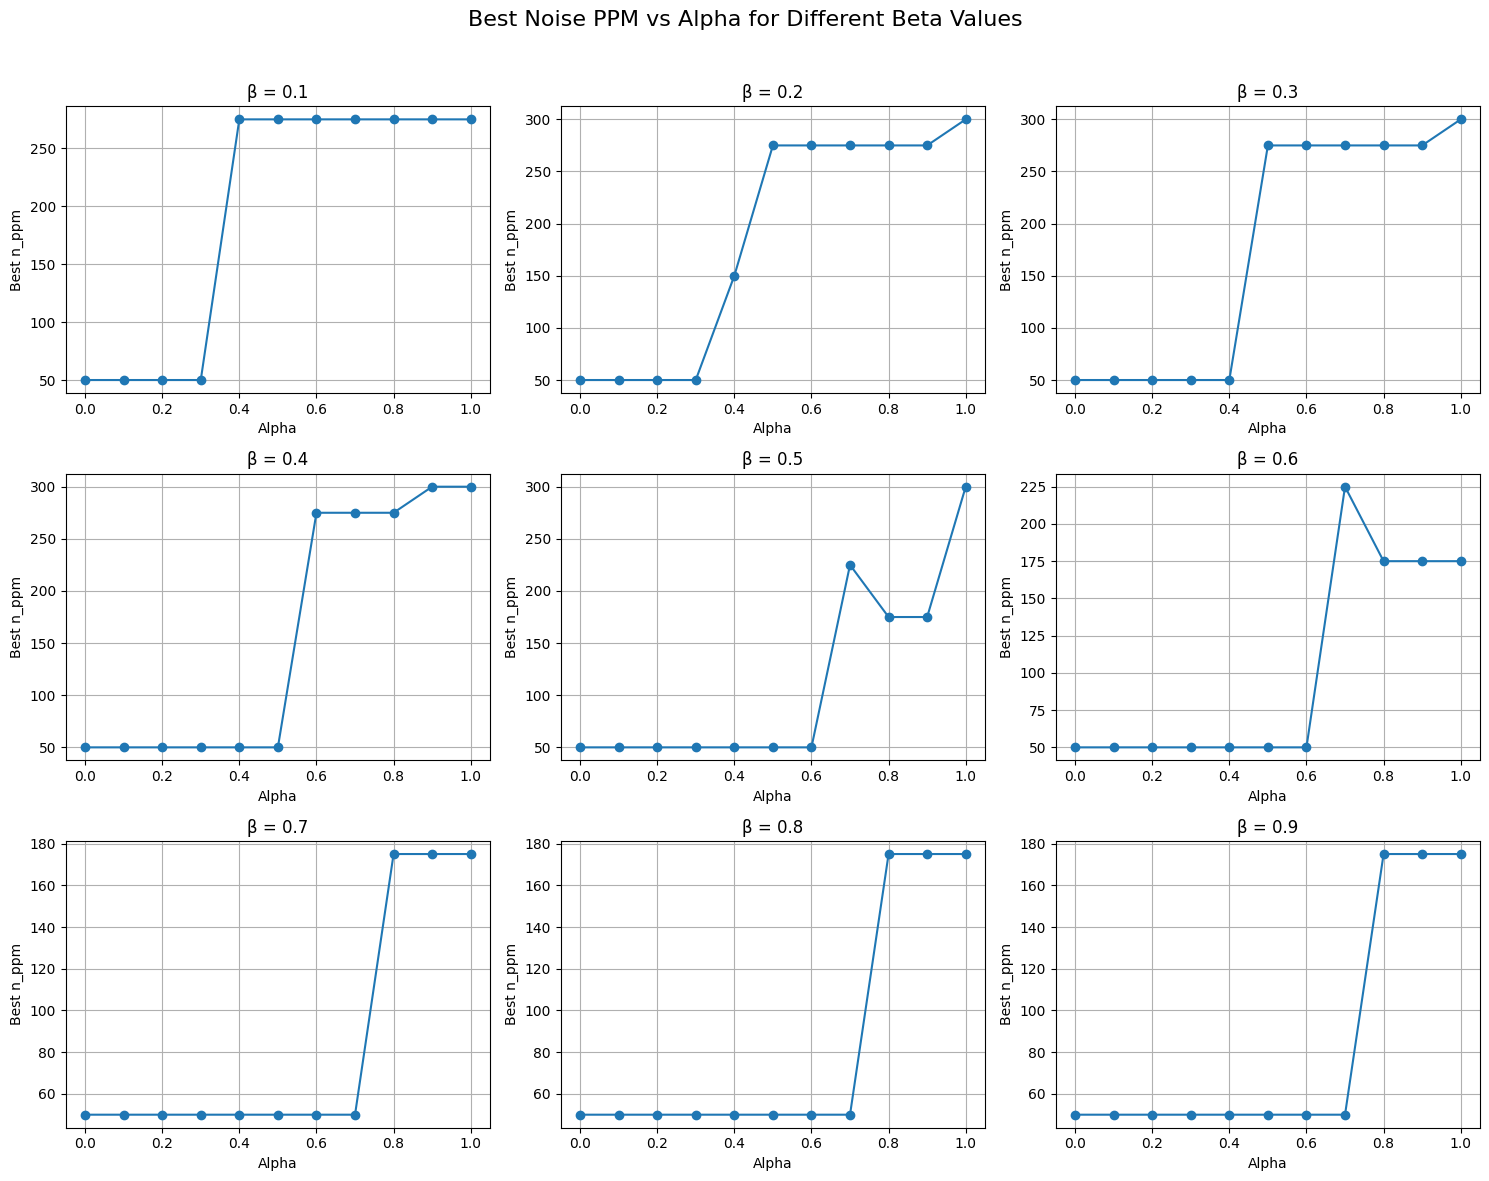

In [216]:
beta_plots = sweep_beta_grid_plot(
    metrics_df,
    n_range=n_range,
    d_range=d_range,
    c_range=c_range,
    nppm_range=nppm_range
)

In [244]:
best = get_best_model_by_alpha(
    metrics_df,
    alpha=0.7, n_range=n_range, d_range=d_range, c_range=c_range, nppm_range=nppm_range,
    beta=0.5
    
)

print(f"Best model variant: {best['variant']}")
print(f"Combined score: {best['combined_score']:.4f}")
print(f"TOI Recall: {best['toi_recall']:.4f}")
print(f"Anomaly Rate: {best['anomaly_rate']:.4f}")
print(f"TOP 10P by Importance present in Top N percent by Anomaly: {best['top_10p_by_importance_percentile_range_upper']:.4f}")

Best model variant: urf4_model_variant_n300_d13_c2_n225ppm_anomaly_scores_sector_2.csv
Combined score: 0.4727
TOI Recall: 0.6304
Anomaly Rate: 0.5889
TOP 10P by Importance present in Top N percent by Anomaly: 34.2228


**Since n_ppm 50e-6 and 225e-6 are most dominant in terms of importance, and n_ppm is the most important feature in terms of importance, we now set n_ppm at 50 and 225 and move on to varying values of duration, with more values in the 13 days to 27 days range**

In [187]:
param_grid = {
    'n_curves': [300],
    'lc_length_days': [0.73, 1.65,
 3.58,  5.10,  8.30, 15.67, 20.0, 24.0],
    'cadence_minutes': [2.0],
    'noise_level': [
        50e-6, 225e-6
    ],
}

# Create all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['n_curves'],
    param_grid['lc_length_days'],
    param_grid['cadence_minutes'],
    param_grid['noise_level'],
))

# Base output path
base_output_folder = "../single_feature_tests/data/synthetic_lcs_variants_duration2/"
os.makedirs(base_output_folder, exist_ok=True)

# Generate and save synthetic light curves with progress bar
for idx, (n, dur, cad, noise) in enumerate(tqdm(param_combinations, desc="Generating Synthetic Variants")):
    # Generate synthetic light curves
    clear_output(wait=True)
    synthetic_lcs, time, model_types = gslc.generate_mixed_transit_lcs(
        n_curves=n,
        lc_length_days=dur,
        cadence_minutes=cad,
        noise_level=noise,
        random_state=42  # for reproducibility
    )

    # Format and create the output directory
    folder_name = f"variant_n{n}_d{dur}_c{int(cad)}_n{int(noise*1e6)}ppm"
    output_folder = os.path.join(base_output_folder, folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Save the synthetic light curves
    gslc.save_synthetic_lcs_npy(
        synthetic_lcs,
        time_vector=time,
        model_types=model_types,
        output_folder=output_folder,
        filename_prefix=f"urf4_sub{output_folder.split("/")[-1]}",
        sector_tag="SIM_URF4_SUBVAR_DUR"
    )

    # Finished log line
    print(f"[✓] Saved variant {idx + 1}/{len(param_combinations)} to: {output_folder}")


Generating Synthetic Variants: 100%|████████████| 16/16 [00:03<00:00,  4.55it/s]

🕒 Saved shared time vector: ../single_feature_tests/data/synthetic_lcs_variants_duration2/variant_n300_d24.0_c2_n225ppm/urf4_subvariant_n300_d24.0_c2_n225ppm_SIM_URF4_SUBVAR_DUR_time.npy
✅ Saved 300 synthetic light curves to: ../single_feature_tests/data/synthetic_lcs_variants_duration2/variant_n300_d24.0_c2_n225ppm
[✓] Saved variant 16/16 to: ../single_feature_tests/data/synthetic_lcs_variants_duration2/variant_n300_d24.0_c2_n225ppm


In [188]:
train_feature_matrices_for_all_variants(base_variant_folder="../single_feature_tests/data/synthetic_lcs_variants_duration2/",
                                            num_flux_points=num_flux_points,
                                            num_freq_points=num_freq_points,
                                            max_workers=4,
                                            save_folder="../single_feature_tests/data/saved_features/urf4_subvariant_synthetic_lcs_features_duration2/")


🔧 Starting feature extraction for 16 variants...



Building features for subvariant_n300_d1.65_c2_n225ppm: 100%|█| 300/300 [01:12<0
Building features for subvariant_n300_d3.58_c2_n225ppm: 100%|█| 300/300 [01:43<0
Building features for subvariant_n300_d3.58_c2_n50ppm: 100%|█| 300/300 [02:12<00
Building features for subvariant_n300_d8.3_c2_n50ppm: 100%|█| 300/300 [03:46<00:
Building features for subvariant_n300_d0.73_c2_n225ppm: 100%|█| 300/300 [00:06<0
Building features for subvariant_n300_d8.3_c2_n225ppm: 100%|█| 300/300 [03:10<00
Building features for subvariant_n300_d1.65_c2_n50ppm: 100%|█| 300/300 [00:13<00
Building features for subvariant_n300_d0.73_c2_n50ppm: 100%|█| 300/300 [00:04<00
Building features for subvariant_n300_d5.1_c2_n50ppm: 100%|█| 300/300 [02:35<00:
Building features for subvariant_n300_d20.0_c2_n50ppm: 100%|█| 300/300 [07:27<00
Building features for subvariant_n300_d5.1_c2_n225ppm: 100%|█| 300/300 [00:29<00
Building features for subvariant_n300_d24.0_c2_n50ppm: 100%|█| 300/300 [04:55<00
Building features for subvar


✅ Feature extraction complete.


['[✓] Processed variant_n300_d20.0_c2_n50ppm',
 '[✓] Processed variant_n300_d3.58_c2_n225ppm',
 '[✓] Processed variant_n300_d1.65_c2_n225ppm',
 '[✓] Processed variant_n300_d8.3_c2_n50ppm',
 '[✓] Processed variant_n300_d3.58_c2_n50ppm',
 '[✓] Processed variant_n300_d8.3_c2_n225ppm',
 '[✓] Processed variant_n300_d1.65_c2_n50ppm',
 '[✓] Processed variant_n300_d0.73_c2_n225ppm',
 '[✓] Processed variant_n300_d5.1_c2_n50ppm',
 '[✓] Processed variant_n300_d0.73_c2_n50ppm',
 '[✓] Processed variant_n300_d24.0_c2_n50ppm',
 '[✓] Processed variant_n300_d5.1_c2_n225ppm',
 '[✓] Processed variant_n300_d24.0_c2_n225ppm',
 '[✓] Processed variant_n300_d15.67_c2_n225ppm',
 '[✓] Processed variant_n300_d15.67_c2_n50ppm',
 '[✓] Processed variant_n300_d20.0_c2_n225ppm']

In [207]:
train_urf4_models_for_all_variants(
    features_folder="../single_feature_tests/data/saved_features/urf4_subvariant_synthetic_lcs_features_duration2/",
    real_feature_path="../single_feature_tests/data/saved_features/urf_training_features/urf_training_feature_run2.npy",
    save_model_folder="../single_feature_tests/models/saved_URF4_subvariants_duration2/",
    model_prefix="urf4_model"
)

16/16 urf4 subvariant models saved


In [209]:
if __name__ == '__main__':
    run_urf4_predictions_all_models(
        model_dir="../single_feature_tests/models/saved_URF4_subvariants_duration2/", # subvariant models
        lightcurve_folder="../single_feature_tests/data/test_set/1/", # test set
        result_dir="../single_feature_tests/results/test_set_1_duration2/", # save results
        max_workers=4, # CPU has 4 cores, so...
        cooldown_seconds=200  # 10 min cooldown after approx 25 mins of processing for 36 times
    )
    

✅ Anomalies found: 3154


Scoring light curves (MP): 100%|████████████| 4000/4000 [18:35<00:00,  3.59it/s]

✅ Multiprocessing scoring complete. Results in: ../single_feature_tests/results/test_set_1_duration2/urf4_model_variant_n300_d8.3_c2_n50ppm_anomaly_scores_sector_2.csv
✅ Done: urf4_model_variant_n300_d8.3_c2_n50ppm.pkl → ../single_feature_tests/results/test_set_1_duration2/urf4_model_variant_n300_d8.3_c2_n50ppm_anomaly_scores_sector_2.csv


In [218]:
metrics_df_VARIABLE_DUR = calculate_auc_metrics_from_results_v4(results_dir="../single_feature_tests/results/test_set_1_duration2//",
                                      sector_no=1,
                                      fits_dir="../single_feature_tests/data/test_set/1/",
                                     )

Accessing TOI data from: https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv
Calculating auc metrics for result: urf4_model_variant_n300_d3.58_c2_n50ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d15.67_c2_n50ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d8.3_c2_n50ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d8.3_c2_n225ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d20.0_c2_n50p

In [221]:
metrics_df_VARIABLE_DUR[["variant", "toi_recall", "anomaly_rate", "top_10p_by_importance_percentile_range_upper", "mean_importance_top20p"]].head()

,variant,toi_recall,anomaly_rate,top_10p_by_importance_percentile_range_upper,mean_importance_top20p
0,urf4_model_variant_n300_d3.58_c2_n50ppm_anomal...,0.873239,0.841476,78.287915,0.166034
1,urf4_model_variant_n300_d15.67_c2_n50ppm_anoma...,0.323944,0.361167,0.897170,0.422812
2,urf4_model_variant_n300_d8.3_c2_n50ppm_anomaly...,0.788732,0.788136,14.041746,0.267876
3,urf4_model_variant_n300_d8.3_c2_n225ppm_anomal...,0.901408,0.875623,77.028181,0.265636
4,urf4_model_variant_n300_d20.0_c2_n50ppm_anomal...,0.661972,0.573529,1.260322,0.422812


In [226]:
metrics_df.to_csv("../single_feature_tests/results/variant_ppm_testset_1_metrics_df_duration2.csv")

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

def extract_metadata(df):
    def parse(s):
        duration_match = re.search(r'_d([0-9.]+)_', s)
        noise_match = re.search(r'_n(\d+)ppm', s)
        ncurves_match = re.search(r'_n(\d+)_', s)  # e.g., _n300_

        if duration_match and noise_match and ncurves_match:
            duration = float(duration_match.group(1))
            noise = int(noise_match.group(1))
            ncurves = int(ncurves_match.group(1))
            return noise, duration, ncurves
        else:
            raise ValueError(f"Could not parse: {s}")
    
    df['noise_ppm'], df['duration_hours'], df['ncurves'] = zip(*df['variant'].map(parse))
    return df

def plot_recall_anomaly_by_duration(df, noise_levels=[50, 225], xlim=None):
    df = extract_metadata(df)

    for noise in noise_levels:
        sub_df = df[df['noise_ppm'] == noise].copy()
        sub_df = sub_df.sort_values(by='duration_hours')

        fig, ax1 = plt.subplots(figsize=(12, 5))
        ax2 = ax1.twinx()

        # Unique colors for each ncurves value
        palette = sns.color_palette('tab10', n_colors=sub_df['ncurves'].nunique())

        for i, (ncurves_val, group) in enumerate(sub_df.groupby('ncurves')):
            group = group.sort_values(by='duration_hours')
            sns.lineplot(x=group['duration_hours'], y=group['toi_recall'],
                         ax=ax1, marker='o', label=f'TOI Recall (n={ncurves_val})',
                         color=palette[i])
            sns.lineplot(x=group['duration_hours'], y=group['anomaly_rate'],
                         ax=ax2, marker='s', label=f'Anomaly Rate (n={ncurves_val})',
                         color=palette[i], linestyle='--')

        ax1.set_xlabel('Transit Duration (hrs)')
        ax1.set_ylabel('TOI Recall', color='tab:blue')
        ax2.set_ylabel('Anomaly Rate', color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax1.set_title(f'TOI Recall vs Anomaly Rate across Duration (Noise = {noise} ppm)')
        ax1.grid(True)

        if xlim:
            ax1.set_xlim(xlim)
            ax2.set_xlim(xlim)

        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        fig.legend(handles1 + handles2, labels1 + labels2,
                   loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=9)

        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.savefig(f"../single_feature_tests/figures/recall_anomaly_vs_duration_n{noise}.png")
        plt.show()

# Example usage:
# plot_recall_anomaly_by_duration(metrics_df_VARIABLE_DUR)


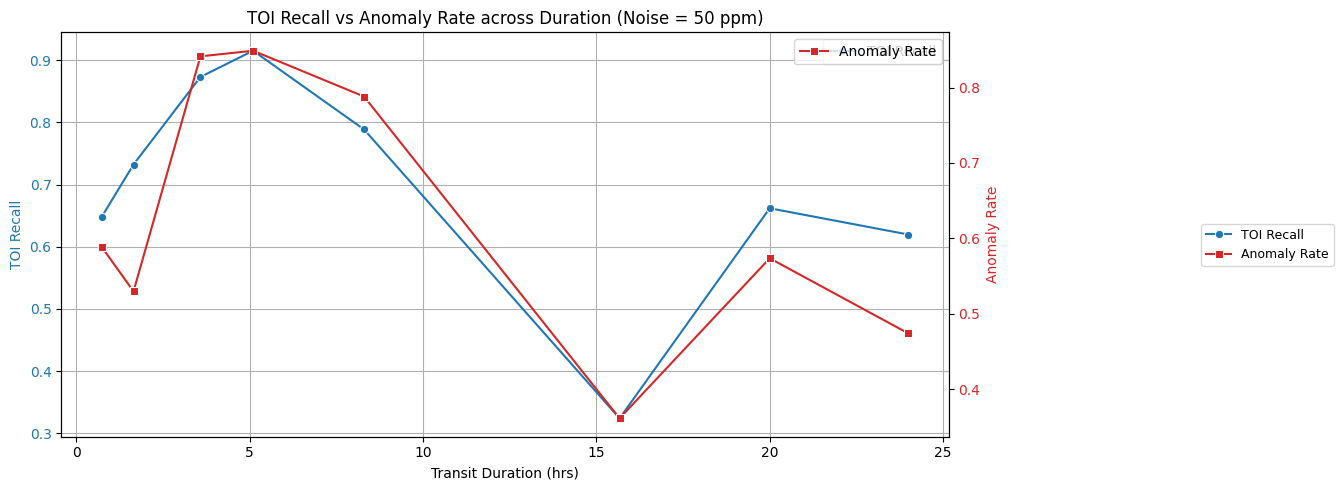

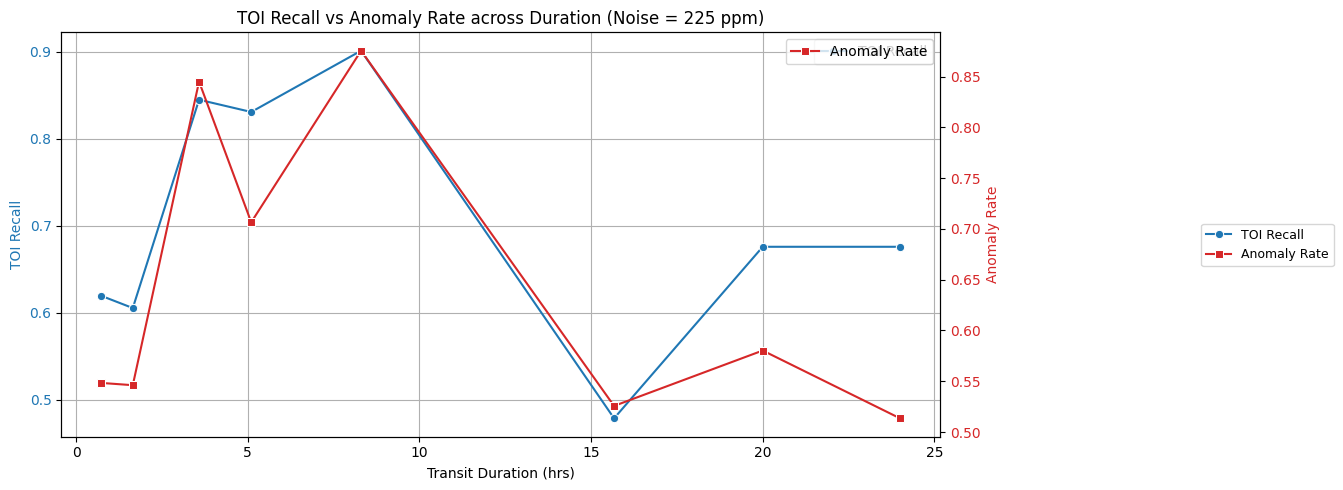

In [229]:
plot_recall_anomaly_by_duration(metrics_df_VARIABLE_DUR)

In [302]:
param_grid = {
    'n_curves': [100],
    'lc_length_days': [23.75, 24.5, 25.25],
    'cadence_minutes': [2.0],
    'noise_level': [
        50e-6, 225e-6
    ],
}

# Create all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['n_curves'],
    param_grid['lc_length_days'],
    param_grid['cadence_minutes'],
    param_grid['noise_level'],
))

# Base output path
base_output_folder = "../single_feature_tests/data/synthetic_lcs_variants_ncurves1/"
os.makedirs(base_output_folder, exist_ok=True)

# Generate and save synthetic light curves with progress bar
for idx, (n, dur, cad, noise) in enumerate(tqdm(param_combinations, desc="Generating Synthetic Variants")):
    # Generate synthetic light curves
    clear_output(wait=True)
    synthetic_lcs, time, model_types = gslc.generate_mixed_transit_lcs(
        n_curves=n,
        lc_length_days=dur,
        cadence_minutes=cad,
        noise_level=noise,
        random_state=42  # for reproducibility
    )

    # Format and create the output directory
    folder_name = f"variant_n{n}_d{dur}_c{int(cad)}_n{int(noise*1e6)}ppm"
    output_folder = os.path.join(base_output_folder, folder_name)
    os.makedirs(output_folder, exist_ok=True)

    # Save the synthetic light curves
    gslc.save_synthetic_lcs_npy(
        synthetic_lcs,
        time_vector=time,
        model_types=model_types,
        output_folder=output_folder,
        filename_prefix=f"urf4_sub{output_folder.split("/")[-1]}",
        sector_tag="SIM_URF4_SUBVAR_DUR"
    )

    # Finished log line
    print(f"[✓] Saved variant {idx + 1}/{len(param_combinations)} to: {output_folder}")


Generating Synthetic Variants: 100%|██████████████| 6/6 [00:00<00:00,  8.51it/s]

🕒 Saved shared time vector: ../single_feature_tests/data/synthetic_lcs_variants_ncurves1/variant_n100_d25.25_c2_n225ppm/urf4_subvariant_n100_d25.25_c2_n225ppm_SIM_URF4_SUBVAR_DUR_time.npy
✅ Saved 100 synthetic light curves to: ../single_feature_tests/data/synthetic_lcs_variants_ncurves1/variant_n100_d25.25_c2_n225ppm
[✓] Saved variant 6/6 to: ../single_feature_tests/data/synthetic_lcs_variants_ncurves1/variant_n100_d25.25_c2_n225ppm


In [303]:
train_feature_matrices_for_all_variants(base_variant_folder="../single_feature_tests/data/synthetic_lcs_variants_ncurves1/",
                                            num_flux_points=num_flux_points,
                                            num_freq_points=num_freq_points,
                                            max_workers=4,
                                            save_folder="../single_feature_tests/data/saved_features/urf4_subvariant_synthetic_lcs_features_ncurves1/")


🔧 Starting feature extraction for 6 variants...



Building features for subvariant_n100_d24.5_c2_n225ppm: 100%|█| 100/100 [01:19<0
Building features for subvariant_n100_d25.25_c2_n50ppm: 100%|█| 100/100 [00:00<0
Building features for subvariant_n100_d23.75_c2_n225ppm: 100%|█| 100/100 [01:34<
Building features for subvariant_n100_d25.25_c2_n225ppm: 100%|█| 100/100 [01:34<
Building features for subvariant_n100_d23.75_c2_n50ppm: 100%|█| 100/100 [01:02<0
Building features for subvariant_n100_d24.5_c2_n50ppm: 100%|█| 100/100 [01:02<00



✅ Feature extraction complete.


['[✓] Processed variant_n100_d25.25_c2_n225ppm',
 '[✓] Processed variant_n100_d25.25_c2_n50ppm',
 '[✓] Processed variant_n100_d23.75_c2_n225ppm',
 '[✓] Processed variant_n100_d24.5_c2_n225ppm',
 '[✓] Processed variant_n100_d23.75_c2_n50ppm',
 '[✓] Processed variant_n100_d24.5_c2_n50ppm']

In [304]:
train_urf4_models_for_all_variants(
    features_folder="../single_feature_tests/data/saved_features/urf4_subvariant_synthetic_lcs_features_ncurves1/",
    real_feature_path="../single_feature_tests/data/saved_features/urf_training_features/urf_training_feature_run2.npy",
    save_model_folder="../single_feature_tests/models/saved_URF4_subvariants_ncurves1/",
    model_prefix="urf4_model"
)

6/6 urf4 subvariant models saved


In [305]:
if __name__ == '__main__':
    run_urf4_predictions_all_models(
        model_dir="../single_feature_tests/models/saved_URF4_subvariants_ncurves1/", # subvariant models
        lightcurve_folder="../single_feature_tests/data/test_set/1/", # test set
        result_dir="../single_feature_tests/results/test_set_1_duration2/", # save results, still saving in duration 2 because duration3 is an extension, more finer division of duration2 feature space
        max_workers=4, # CPU has 4 cores, so...
        cooldown_seconds=200  # 10 min cooldown after approx 25 mins of processing for 36 times
    )

✅ Anomalies found: 1596


Scoring light curves (MP): 100%|████████████| 4000/4000 [18:29<00:00,  3.61it/s]

✅ Multiprocessing scoring complete. Results in: ../single_feature_tests/results/test_set_1_duration2/urf4_model_variant_n100_d25.25_c2_n50ppm_anomaly_scores_sector_2.csv
✅ Done: urf4_model_variant_n100_d25.25_c2_n50ppm.pkl → ../single_feature_tests/results/test_set_1_duration2/urf4_model_variant_n100_d25.25_c2_n50ppm_anomaly_scores_sector_2.csv


In [306]:
metrics_df_VARIABLE_DUR_finer1 = calculate_auc_metrics_from_results_v4(results_dir="../single_feature_tests/results/test_set_1_duration2//",
                                      sector_no=1,
                                      fits_dir="../single_feature_tests/data/test_set/1/",
                                     ) # more finer division of duration 20 days to 27 days across two different ppms. one low 50 and another high 225

Accessing TOI data from: https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv
Calculating auc metrics for result: urf4_model_variant_n300_d24.75_c2_n50ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d24.5_c2_n225ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d12.0_c2_n225ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d25.25_c2_n50ppm_anomaly_scores_sector_2.csv
✓ Found 71 TOIs with importance scores.
['filename', 'tic_id', 'importance_score', 'normalized_score']
Calculating auc metrics for result: urf4_model_variant_n300_d21.5_c2_

In [308]:
metrics_df_VARIABLE_DUR_finer1.to_csv("../single_feature_tests/results/variant_ppm_testset_1_metrics_df_duration5.csv")

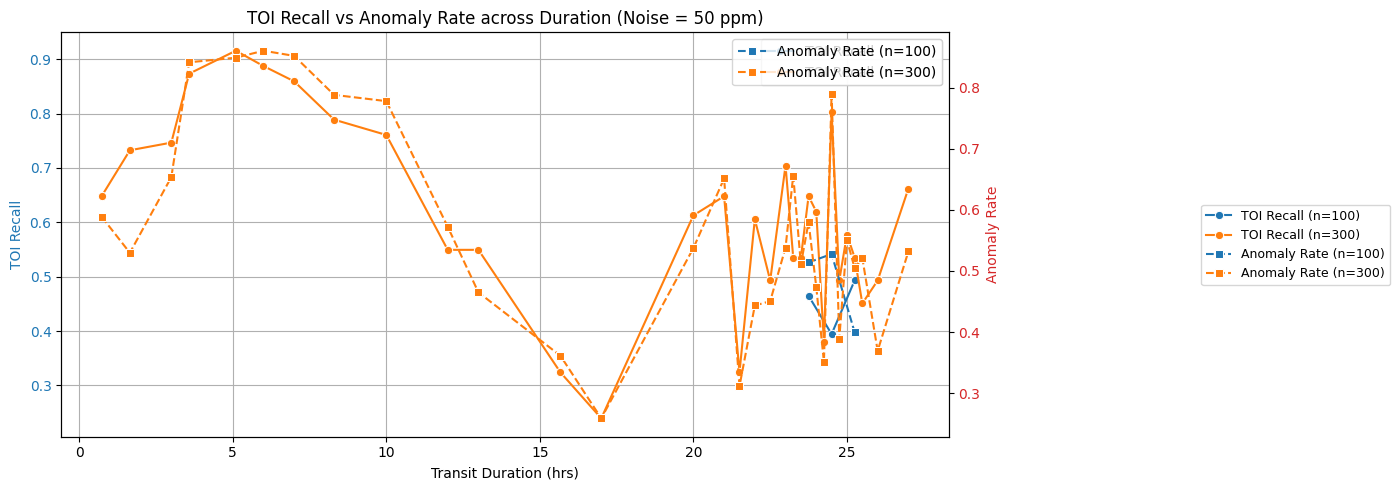

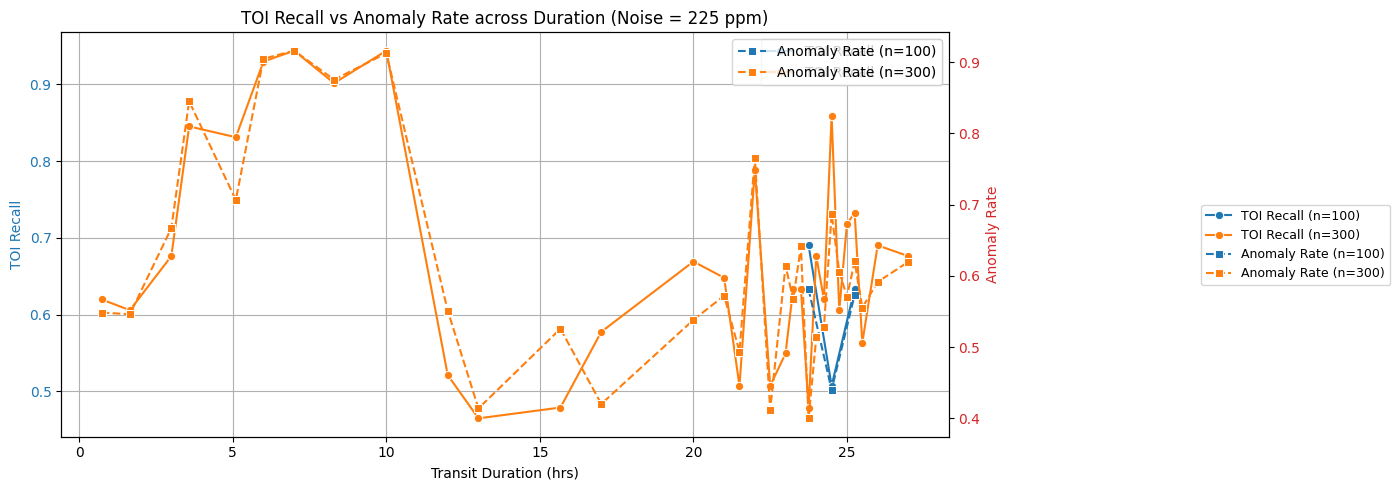

In [309]:
plot_recall_anomaly_by_duration(metrics_df_VARIABLE_DUR_finer1)

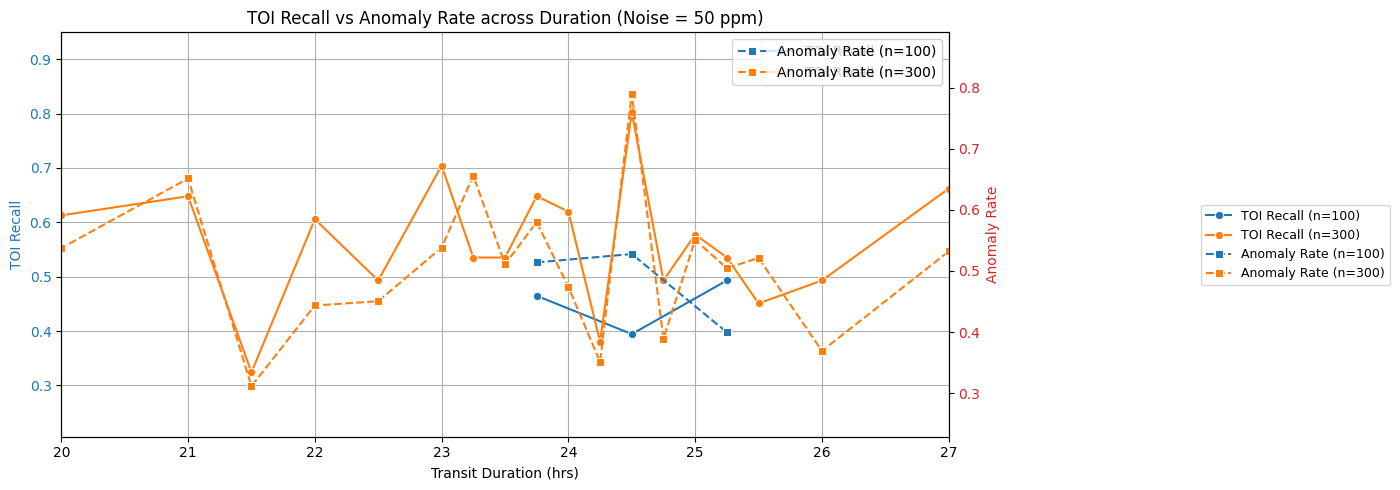

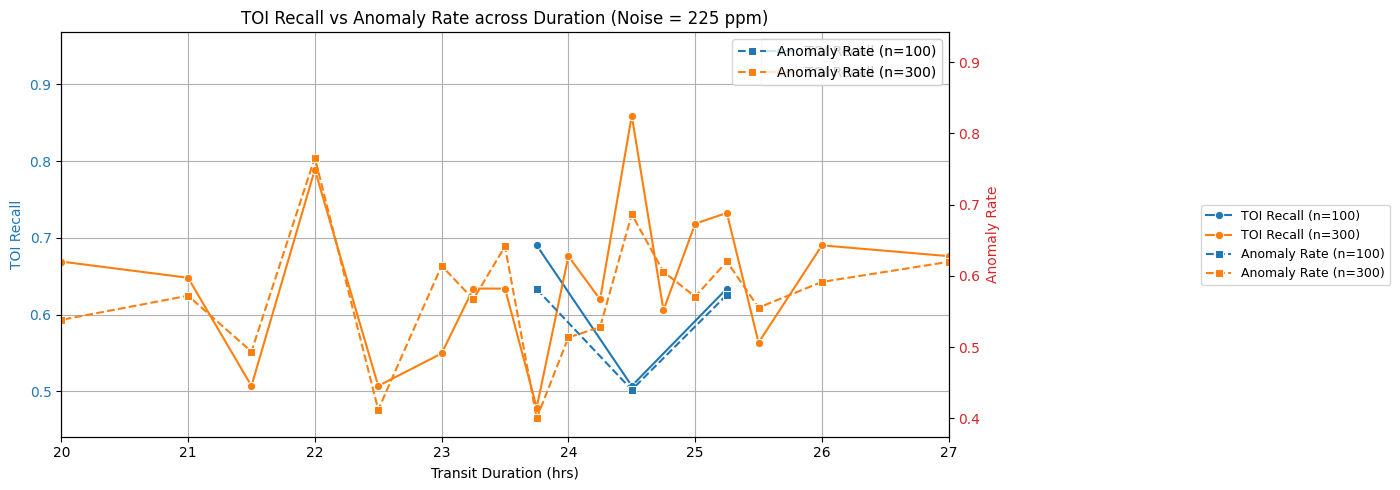

In [310]:
plot_recall_anomaly_by_duration(metrics_df_VARIABLE_DUR_finer1, xlim=(20,27))

In [311]:
#metrics_df_VARIABLE_DUR_finer1[["variant", "toi_recall", "anomaly_rate", "top_10p_by_importance_percentile_range_upper", "mean_importance_top20p"]]
metrics_df_VARIABLE_DUR_finer1_11 = metrics_df_VARIABLE_DUR_finer1.copy()
metrics_df_VARIABLE_DUR_finer1_11["recall_anomaly_delta"] = metrics_df_VARIABLE_DUR_finer1_11["toi_recall"] - metrics_df_VARIABLE_DUR_finer1_11["anomaly_rate"]
metrics_df_VARIABLE_DUR_finer1_11[["variant", "toi_recall", "anomaly_rate", "recall_anomaly_delta", "mean_importance_top20p", "top_10p_by_importance_percentile_range_upper"]].sort_values(by='mean_importance_top20p', ascending=True)

,variant,toi_recall,anomaly_rate,recall_anomaly_delta,mean_importance_top20p,top_10p_by_importance_percentile_range_upper
61,urf4_model_variant_n300_d1.65_c2_n50ppm_anomal...,0.732394,0.529661,0.202733,0.128009,58.823529
67,urf4_model_variant_n300_d6.0_c2_n50ppm_anomaly...,0.887324,0.860419,0.026905,0.136765,94.524913
14,urf4_model_variant_n300_d6.0_c2_n225ppm_anomal...,0.929577,0.905035,0.024543,0.141217,95.235472
57,urf4_model_variant_n300_d5.1_c2_n225ppm_anomal...,0.830986,0.706630,0.124356,0.153325,79.223986
40,urf4_model_variant_n300_d5.1_c2_n50ppm_anomaly...,0.915493,0.848953,0.066540,0.153658,84.380505
...,...,...,...,...,...,...
29,urf4_model_variant_n300_d24.5_c2_n50ppm_anomal...,0.802817,0.789880,0.012937,0.450153,19.122752
62,urf4_model_variant_n300_d25.25_c2_n225ppm_anom...,0.732394,0.620140,0.112255,0.450153,19.734727
39,urf4_model_variant_n300_d23.0_c2_n225ppm_anoma...,0.549296,0.614158,-0.064862,0.456235,50.852273
64,urf4_model_variant_n300_d26.0_c2_n50ppm_anomal...,0.492958,0.369143,0.123815,0.456235,99.594868


In [312]:
metrics_df_VARIABLE_DUR_finer1_11[[
    "recall_anomaly_delta",
    "mean_importance_top20p",
    #"top_10p_by_importance_percentile_range_upper"
]].corr()

,recall_anomaly_delta,mean_importance_top20p
recall_anomaly_delta,1.00000,0.00726
mean_importance_top20p,0.00726,1.00000


In [313]:
def compute_combined_score_with_alpha(df, alpha=0.7):
    df = df.copy()

    # Invert metrics where lower is better
    df['inv_anomaly_rate'] = 1 - MinMaxScaler().fit_transform(df[['anomaly_rate']])
    df['inv_top10p_range'] = 1 - MinMaxScaler().fit_transform(df[['top_10p_by_importance_percentile_range_upper']])

    # Normalize all others
    df['norm_toi_recall'] = MinMaxScaler().fit_transform(df[['toi_recall']])
    df['norm_recall_anomaly_delta'] = MinMaxScaler().fit_transform(df[['recall_anomaly_delta']])
    df['norm_importance'] = MinMaxScaler().fit_transform(df[['mean_importance_top20p']])

    # Detection group weights (total = alpha)
    w_recall = 0.5 * alpha
    w_anomaly_inv = 0.2 * alpha
    w_delta = 0.3 * alpha

    # Interpretability group weights (total = 1 - alpha)
    w_importance = 0.5 * (1 - alpha)
    w_top10_range = 0.5 * (1 - alpha)

    # Combined score
    df['combined_score'] = (
        w_recall * df['norm_toi_recall'] +
        w_anomaly_inv * df['inv_anomaly_rate'] +
        w_delta * df['norm_recall_anomaly_delta'] +
        w_importance * df['norm_importance'] +
        w_top10_range * df['inv_top10p_range']
    )

    df['rank'] = df['combined_score'].rank(ascending=False)
    return df.sort_values(by='combined_score', ascending=False)


In [314]:
compute_combined_score_with_alpha(metrics_df_VARIABLE_DUR_finer1_11, alpha=0.9)[["variant", "toi_recall", "anomaly_rate", "recall_anomaly_delta", "mean_importance_top20p", "top_10p_by_importance_percentile_range_upper"]].head()

,variant,toi_recall,anomaly_rate,recall_anomaly_delta,mean_importance_top20p,top_10p_by_importance_percentile_range_upper
1,urf4_model_variant_n300_d24.5_c2_n225ppm_anoma...,0.859155,0.686441,0.172714,0.370046,81.953522
61,urf4_model_variant_n300_d1.65_c2_n50ppm_anomal...,0.732394,0.529661,0.202733,0.128009,58.823529
30,urf4_model_variant_n300_d23.0_c2_n50ppm_anomal...,0.704225,0.538136,0.166090,0.422812,63.779528
33,urf4_model_variant_n300_d24.0_c2_n225ppm_anoma...,0.676056,0.513460,0.162597,0.422812,54.611650
62,urf4_model_variant_n300_d25.25_c2_n225ppm_anom...,0.732394,0.620140,0.112255,0.450153,19.734727


In [315]:
compute_combined_score_with_alpha(metrics_df_VARIABLE_DUR_finer1_11, alpha=0.3)[["variant", "toi_recall", "anomaly_rate", "recall_anomaly_delta", "mean_importance_top20p", "top_10p_by_importance_percentile_range_upper"]].head()

,variant,toi_recall,anomaly_rate,recall_anomaly_delta,mean_importance_top20p,top_10p_by_importance_percentile_range_upper
24,urf4_model_variant_n300_d23.75_c2_n50ppm_anoma...,0.647887,0.580010,0.067877,0.422812,2.535453
43,urf4_model_variant_n100_d25.25_c2_n225ppm_anom...,0.633803,0.573280,0.060523,0.422812,1.739130
62,urf4_model_variant_n300_d25.25_c2_n225ppm_anom...,0.732394,0.620140,0.112255,0.450153,19.734727
31,urf4_model_variant_n300_d21.0_c2_n50ppm_anomal...,0.647887,0.651296,-0.003409,0.422812,1.492537
29,urf4_model_variant_n300_d24.5_c2_n50ppm_anomal...,0.802817,0.789880,0.012937,0.450153,19.122752


In [316]:
compute_combined_score_with_alpha(metrics_df_VARIABLE_DUR_finer1_11, alpha=0.5)[["variant", "toi_recall", "anomaly_rate", "recall_anomaly_delta", "mean_importance_top20p", "top_10p_by_importance_percentile_range_upper"]].head()

,variant,toi_recall,anomaly_rate,recall_anomaly_delta,mean_importance_top20p,top_10p_by_importance_percentile_range_upper
62,urf4_model_variant_n300_d25.25_c2_n225ppm_anom...,0.732394,0.620140,0.112255,0.450153,19.734727
24,urf4_model_variant_n300_d23.75_c2_n50ppm_anoma...,0.647887,0.580010,0.067877,0.422812,2.535453
43,urf4_model_variant_n100_d25.25_c2_n225ppm_anom...,0.633803,0.573280,0.060523,0.422812,1.739130
29,urf4_model_variant_n300_d24.5_c2_n50ppm_anomal...,0.802817,0.789880,0.012937,0.450153,19.122752
54,urf4_model_variant_n100_d23.75_c2_n225ppm_anom...,0.690141,0.581256,0.108885,0.422812,25.557461


In [318]:
# run 3 top models from combined score ranking with alpha values of 0.3, 0.5, 0.9 on the whole of sector 1 
import clara_urf_predictor as cupred

predictions_point3_s1 = cupred.get_anomaly_scores_from_folder_parallelized_streamed_mp(
    model_path="../single_feature_tests/models/allmodels/urf4_model_variant_n300_d23.75_c2_n50ppm.pkl",
    folder_path="/media/violet/Expansion/1/",
    save_csv="../results_part2/point3_sector1_anomalyscores_300_23-75_2_50/scores_s1_point3_urf4_model_variant_n300_d23.75_c2_n50ppm_results.csv",
    max_workers=4
)

✅ Anomalies found: 9250


Scoring light curves (MP): 100%|████████| 15878/15878 [1:29:25<00:00,  2.96it/s]

✅ Multiprocessing scoring complete. Results in: ../results_part2/point3_sector1_anomalyscores_300_23-75_2_50/scores_s1_point3_urf4_model_variant_n300_d23.75_c2_n50ppm_results.csv


In [319]:
predictions_point9_s1 = cupred.get_anomaly_scores_from_folder_parallelized_streamed_mp(
    model_path="../single_feature_tests/models/allmodels/urf4_model_variant_n300_d24.5_c2_n225ppm.pkl",
    folder_path="/media/violet/Expansion/1/",
    save_csv="../results_part2/point9_sector1_anomalyscores_300_24-50_2_225/scores_s1_point9_urf4_model_variant_n300_d24.5_c2_n225ppm_results.csv",
    max_workers=4
)

✅ Anomalies found: 10865


Scoring light curves (MP): 100%|████████| 15878/15878 [1:26:46<00:00,  3.05it/s]

✅ Multiprocessing scoring complete. Results in: ../results_part2/point9_sector1_anomalyscores_300_24-50_2_225/scores_s1_point9_urf4_model_variant_n300_d24.5_c2_n225ppm_results.csv


In [320]:
predictions_point5_s1 = cupred.get_anomaly_scores_from_folder_parallelized_streamed_mp(
    model_path="../single_feature_tests/models/allmodels/urf4_model_variant_n300_d25.25_c2_n225ppm.pkl",
    folder_path="/media/violet/Expansion/1/",
    save_csv="../results_part2/point5_sector1_anomalyscores_300_25-25_2_225/scores_s1_point5_urf4_model_variant_n300_d25.25_c2_n225ppm_results.csv",
    max_workers=4
)

✅ Anomalies found: 9835


Scoring light curves (MP): 100%|████████| 15878/15878 [1:23:21<00:00,  3.17it/s]

✅ Multiprocessing scoring complete. Results in: ../results_part2/point5_sector1_anomalyscores_300_25-25_2_225/scores_s1_point5_urf4_model_variant_n300_d25.25_c2_n225ppm_results.csv
